In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import DenseNet121
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os 
import cv2
warnings.filterwarnings('ignore')

2024-08-29 12:12:59.907438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 12:12:59.907490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 12:12:59.908929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Data

In [3]:
xtrain = []
ytrain = []
image_size = 150
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri/Training', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(image_size, image_size))
        xtrain.append(img)
        ytrain.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri/Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(image_size, image_size))
        xtrain.append(img)
        ytrain.append(i)
        
xtrain = np.array(xtrain)
ytrain = np.array(ytrain) 

In [4]:
xtrain,ytrain = shuffle(xtrain,ytrain, random_state = 42)
xtrain.shape

(3264, 150, 150, 3)

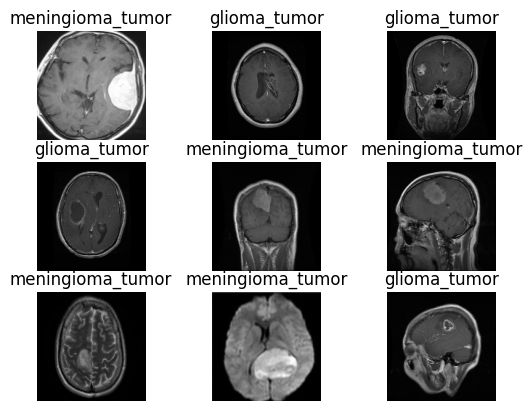

In [5]:
for i in range(9):
    plt.Figure(figsize=(10,12))
    plt.subplot(3,3,i+1)
    plt.imshow(xtrain[i])
    plt.title(ytrain[i])
    plt.axis('off')

In [6]:
xtrain,xtest,ytrain,ytest = train_test_split(xtrain, ytrain, test_size = 0.2, random_state = 42)

In [7]:
ytrain[:20]

array(['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor',
       'glioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'glioma_tumor',
       'no_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor',
       'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor',
       'pituitary_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor',
       'glioma_tumor', 'glioma_tumor'], dtype='<U16')

# Normalizing image pixels

In [8]:
def process(image):
    image = tf.cast(image/255 , tf.float32)
    return image

In [9]:
xtrain = process(xtrain)
xtest = process(xtest)

# One Hot Encoding Target columns

In [10]:
ytrain_new = []
for i in ytrain:
    ytrain_new.append(labels.index(i))
ytrain=ytrain_new
ytrain = tf.keras.utils.to_categorical(ytrain)

ytest_new = []
for i in ytest:
    ytest_new.append(labels.index(i))
ytest=ytest_new
ytest = tf.keras.utils.to_categorical(ytest)

In [11]:
ytrain = np.array(ytrain)
ytest = np.array(ytest)

In [12]:
print(xtrain.shape)
print(ytrain.shape)

(2611, 150, 150, 3)
(2611, 4)


# Modelling

In [13]:
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape= (150,150,3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
conv_base.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [15]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if 'conv5_block16' in layer.name :
        set_trainable = True
    #if 'conv5_block15' in layer.name:
     #   set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_layer False
zero_padding2d False
conv1_conv False
conv1_bn False
conv1_relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_

In [16]:
model = Sequential()

model.add(conv_base)
model.add(GlobalAveragePooling2D())
#model.add(MaxPooling2D())
model.add(Dropout(0.5))


#model.add(Flatten())

#model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, min_delta=0.001, patience= 3)
ES = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=7, verbose=1)
checkpoint = ModelCheckpoint('densenet.keras', monitor = 'val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [19]:
history = model.fit(xtrain, ytrain, epochs=25, validation_split = 0.1,
                    batch_size=16, callbacks=[reduce_lr,ES,checkpoint])

Epoch 1/25
  3/147 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2188 - loss: 2.3769    

I0000 00:00:1724933733.027043     276 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724933733.096588     276 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3737 - loss: 1.5099

W0000 00:00:1724933754.656437     274 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724933764.415482     273 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.77863, saving model to densenet.keras


W0000 00:00:1724933776.303751     275 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 303ms/step - accuracy: 0.3744 - loss: 1.5079 - val_accuracy: 0.7786 - val_loss: 0.6110 - learning_rate: 0.0010
Epoch 2/25
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6372 - loss: 0.8740
Epoch 2: val_accuracy improved from 0.77863 to 0.83969, saving model to densenet.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6377 - loss: 0.8733 - val_accuracy: 0.8397 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 3/25
145/147 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7204 - loss: 0.7003
Epoch 3: val_accuracy improved from 0.83969 to 0.88168, saving model to densenet.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7209 - loss: 0.6996 - val_accuracy: 0.8817 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7705 - loss: 0.6069
Epoch 4: val_accuracy improved from 0.88168 to 0.89313, saving model to densenet.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accura

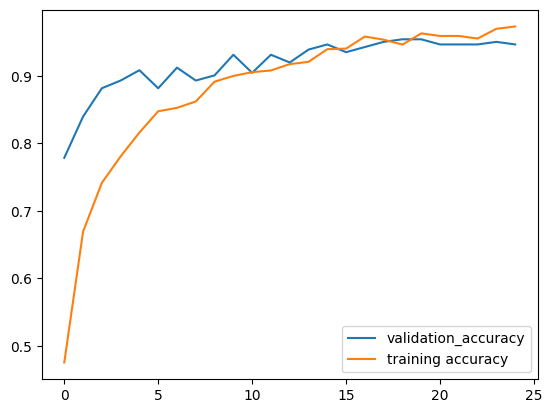

In [20]:
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

# Predicting

In [21]:
ypred = model.predict(xtest)

 5/21 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

W0000 00:00:1724933929.705211     275 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 502ms/step


W0000 00:00:1724933939.747252     274 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [22]:
ypred  = np.argmax(ypred, axis=1)
ytest = np.argmax(ytest, axis=1)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       198
           1       0.91      0.94      0.93       178
           2       0.98      0.97      0.98       105
           3       0.98      0.95      0.96       172

    accuracy                           0.95       653
   macro avg       0.95      0.95      0.95       653
weighted avg       0.95      0.95      0.95       653

